<a href="https://colab.research.google.com/github/nishinorinsei/nishinorinsei.github.io/blob/main/ensyu_3_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DUETを用いた音源分離


ここではDUETを用いた音源分離を実装しましょう．

---

必要なモジュールをインストール & インポートします．

In [30]:
!pip install japanize-matplotlib -U
!pip install pesq

In [31]:
import numpy as np
import scipy.signal as sg          #  信号処理モジュール
import soundfile as sf              # wavファイルを扱う際のモジュール
from IPython.display import *  # iPython上でファイルを扱うためのモジュール
import urllib.request                # ファイルを読み込むためのモジュール
import matplotlib.pyplot as plt # 図を表示させるためのモジュール
import japanize_matplotlib      # 日本語を扱うためのモジュール
from pesq import pesq        # 音声評価用関数
from statistics import mode     # 最頻値計算用関数

## 0. 音声の読み込みと確認
音声ファイルの読み込みを行います．

```
音声ファイル群：
・ original_1.wav - 音源A
・ original_2.wav - 音源B
・ sound_SpeakerA.wav - 音源Aのみを収録したステレオ音声
・ sound_SpeakerB.wav - 音源Bのみを収録したステレオ音声
・ sound_2souces_duet.wav - 音源Aと音源Bを同時に収録したステレオ音声
```

収録されたステレオ音声`sound_2souces_duet.wav`に音源分離を行います．
左右のチャンネルの音声をそれぞれ x_l，x_r とします．

また，DUETでは事前に各音源ごとに振幅比を計算する必要があります．
振幅比を

また，音声信号の各サンプルに対応する時刻[s]をもった配列として t を作成します．

In [32]:
# wavファイルをGoogle colabのワークスペースにもってくる
base_url = 'https://raw.githubusercontent.com/YosukeSugiura/SougouEnshu-A/master/' # Githubでrawデータを扱うためのurl
urllib.request.urlretrieve(base_url+'sound_2souces_duet.wav', 'sound_2souces_duet.wav') # マイクで収録したステレオ音声
urllib.request.urlretrieve(base_url+'sound_SpeakerA.wav', 'sound_SpeakerA.wav') # 音源Aのみ収録したステレオ音声
urllib.request.urlretrieve(base_url+'sound_SpeakerB.wav', 'sound_SpeakerB.wav') # 音源Bのみ収録したステレオ音声
urllib.request.urlretrieve(base_url+'original_1.wav', 'original_1.wav') # 音源A
urllib.request.urlretrieve(base_url+'original_2.wav', 'original_2.wav') # 音源B

# wavファイルの読み込み (sf.readの戻り値：データ，サンプリング周波数)
wav_data, fs = sf.read('sound_2souces_duet.wav')  # マイクで収録したステレオ音声 (原音声1+原音声２)

# 事前に振幅比を計算するwavファイル
soundA, _ = sf.read('sound_SpeakerA.wav')  # 音源Aのみ事前に収録したステレオ音声
soundB, _ = sf.read('sound_SpeakerB.wav')  # 音源Bのみ事前に収録したステレオ音声

originalA, _ = sf.read('original_1.wav')  # 音源A
originalB, _ = sf.read('original_2.wav')  # 音源B

# 各音声をチャンネルごとに分ける
# - 処理対象の音声
x_l = wav_data[:,0]
x_r = wav_data[:,1]
# - 音源Aのみ事前に収録した音声
soundA_l = soundA[:,0]
soundA_r = soundA[:,1]
# - 音源Bのみ事前に収録した音声
soundB_l = soundB[:,0]
soundB_r = soundB[:,1]

# 各サンプルの時刻(波形の図示で使う)
t   = np.arange(len(x_l))/fs
t1 = np.arange(len(originalA))/fs
t2 = np.arange(len(originalB))/fs

振幅比を計算する音声を聞くこともできます(イヤホン推奨)．

In [33]:
print('音源Aのみの音声(事前推定用)')
display(Audio(soundA.T, rate=fs))
print('音源Bのみの音声(事前推定用)')
display(Audio(soundB.T, rate=fs))

音源Aのみの音声(事前推定用)


音源Bのみの音声(事前推定用)


## 1. 各音源の振幅比の事前推定

各音源が混合されず単体で収録された音声を用いて，事前に振幅比を計算します．
DUETでは，この振幅比に基づき音源を分離します．

まずはSTFTのパラメータを設定します．

In [34]:
# セグメント長，シフト長の指定
n_seg = 1024
n_overlap = round(1024*(1/2))

音源A，音源Bのみの音声をそれぞれSTFTします．

In [35]:
# 音源Aのスペクトログラム
_, _, Xa_l = sg.stft(soundA_l, fs=fs, nperseg=n_seg, noverlap=n_overlap) # 左チャンネル
_, _, Xa_r = sg.stft(soundA_r, fs=fs, nperseg=n_seg, noverlap=n_overlap) # 右チャンネル
# 音源Bのスペクトログラム
_, _, Xb_l = sg.stft(soundB_l, fs=fs, nperseg=n_seg, noverlap=n_overlap) # 左チャンネル
_, _, Xb_r = sg.stft(soundB_r, fs=fs, nperseg=n_seg, noverlap=n_overlap) # 右チャンネル

信号のSTFT結果から振幅比を計算します．
音源Aにおける左チャンネルのスペクトログラムを`X_al`，右チャンネルのスペクトログラムを`X_ar`とします．
このとき，振幅比は

```
R_a = |X_al|/|X_ar|
```

で計算されます．音源Bにおいても振幅比を同様に計算し，`R_b`とします．

In [36]:
#↓↓ 自身で書き換えて，音源A・Bそれぞれの振幅比R_a, R_bを計算する．
#--------------------------------------
R_a = np.abs(Xa_l) / np.abs(Xa_r)
R_b = np.abs(Xb_l) / np.abs(Xb_r)
#--------------------------------------
#↑↑ここまで

振幅比のヒストグラムを計算し，最頻値を計算します．

In [37]:
# 音源Aにおける振幅比 R_a のヒストグラムと最頻値
hist_ra, edge_ra = np.histogram(R_a.flatten(), bins=200, range=(0,4))
Ra_mod = edge_ra[hist_ra.argmax()] # ヒストグラム hist_ra の最頻値

# 音源Bにおける振幅比 R_b のヒストグラムと最頻値
hist_rb, edge_rb = np.histogram(R_b.flatten(), bins=200, range=(0,4))
Rb_mod = edge_rb[hist_rb.argmax()] # ヒストグラム hist_ra の最頻値

得られた最頻値を出力します．

In [38]:
print("振幅比の最頻値：\n  音源A = {0:.4},\n  音源B = {1:.4}".format(Ra_mod, Rb_mod))

振幅比の最頻値：
  音源A = 1.98,
  音源B = 1.16


確認のため，振幅比のヒストグラムを表示します．

Text(0.5, -0.4, '音源Bの振幅比のヒストグラム')

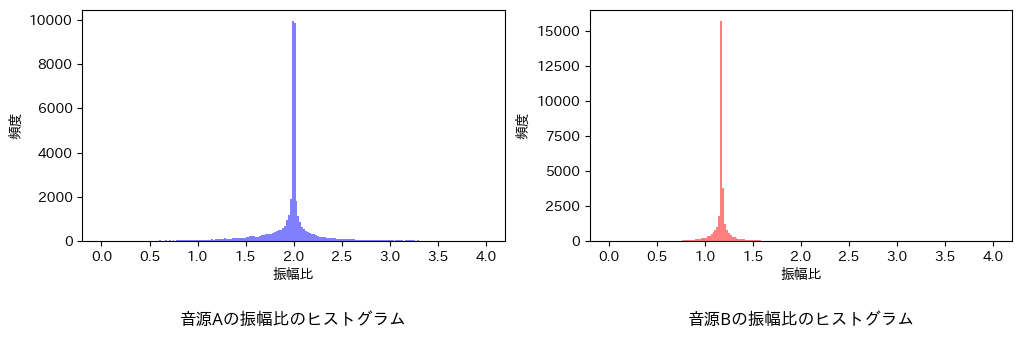

In [39]:
fig3, ax3 = plt.subplots(1, 2, num=1, figsize=(12,3))
_, _, _ = ax3[0].hist(R_a.flatten(), bins=200, alpha=0.5, histtype='stepfilled', range=(0,4), color='b')
_, _, _ = ax3[1].hist(R_b.flatten(), bins=200, alpha=0.5, histtype='stepfilled', range=(0,4), color='r')
for ax_ in ax3:
  ax_.set_xlabel("振幅比")
  ax_.set_ylabel("頻度")
ax3[0].set_title("音源Aの振幅比のヒストグラム", y=-0.4)
ax3[1].set_title("音源Bの振幅比のヒストグラム", y=-0.4)

## 2. DUETによる音源分離

バイナリマスキングと同様，振幅比に基づき周波数マスクを作成して，音源分離を行いましょう．

まずは音声をフレームごとに分割して，短時間フーリエ変換(STFT)を行います．


In [40]:
# 各チャンネルごとに短時間フーリエ変換
f, t, X_l = sg.stft(x_l, fs=fs, nperseg=n_seg, noverlap=n_overlap) # 左チャンネル
_, _, X_r = sg.stft(x_r, fs=fs, nperseg=n_seg, noverlap=n_overlap) # 右チャンネル

マスクを作成し，フィルタリングを行いましょう．まずは音声の振幅比 R を計算し，以下のようにマスクを計算します．

マスクの設定：

  振幅比 R = |X_l| / |X_r| とすると
- 音源Aのマスク G_a： Ra_mod - sig < R <  Ra_mod + sig を満たすとき 1 ,その他で0
- 音源Bのマスク G_b： Rb_mod - sig < R <  Rb_mod + sig を満たすとき 1, その他で0

In [41]:
# マスクの作成

#↓↓ ここに音源分離を実現するマスクを作成しよう！
#     このサンプルコードでは，マスクのすべての値を1(=すべての周波数成分をそのまま通過させる)にしています．
#     自身で書き換えて，音源分離を実装しましょう．
#--------------------------------------
sig = 0.3
R = np.abs(X_l) / (np.abs(X_r)+1e-10)
# - 左チャンネル
G_a = ((R > (Ra_mod - sig)) & (R < (Ra_mod + sig))).astype(float)   # X_lと同じサイズのマスクを作成


# - 右チャンネル
G_b = ((R > (Rb_mod - sig)) & (R < (Rb_mod + sig))).astype(float)   # X_lと同じサイズのマスクを作成

#--------------------------------------
#↑↑ここまで

# スペクトログラムをマスキング
Y_a = G_a * X_l
Y_b = G_b * X_r

各チャンネルの音声のスペクトログラムを図で確認します．ここでは音声の特徴が見やすいように，0Hz～2kHzまでを表示しています．

(このサンプルコードは，入力音声をそのまま出力するフィルタリングを行っています．したがってオリジナルのままでは，入力音声と同じスペクトログラムが得られます．)

Text(0.5, -0.1, '分離音源のスペクトログラム(左：音源A，右：音源B)')

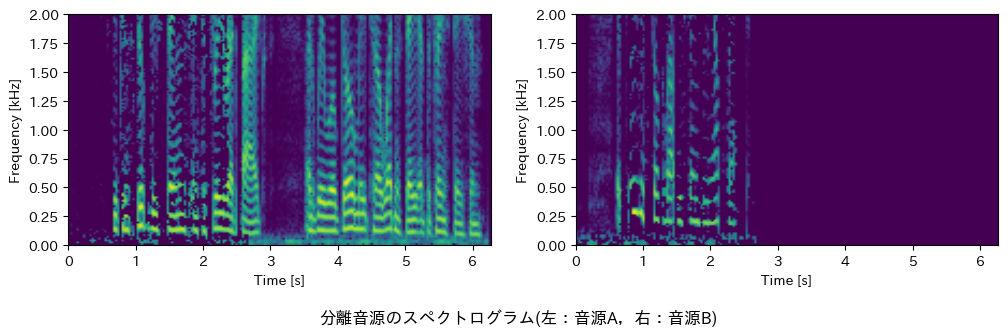

In [42]:
# パワースペクトログラムの計算
# 処理後の音声
S_a = 10*np.log10(np.abs(Y_a)**2+10**(-8))  # dB単位
S_b = 10*np.log10(np.abs(Y_b)**2+10**(-8)) # dB単位

# 1 x 2 のグラフを作成
fig3, ax3 = plt.subplots(1, 2, num=1, figsize=(12,3))

# 各グラフをプロット
extent = [t.min(), t.max(), f.min()/1000, f.max()/1000] # 時間の範囲
ax3[0].imshow(S_a, aspect='auto', origin='lower', interpolation='bilinear', extent=extent)
ax3[1].imshow(S_b, aspect='auto', origin='lower', interpolation='bilinear', extent=extent)

# 軸名・範囲・タイトルの設定
for ax_ in ax3:
  ax_.set_ylim([0,2]) # 各グラフ，0~2kHzまでを表示
  ax_.set_ylabel("Frequency [kHz]")
  ax_.set_xlabel("Time [s]")
fig3.suptitle("分離音源のスペクトログラム(左：音源A，右：音源B)", y=-0.1)

処理音声に対して逆短時間フーリエ変換(Inverse Short Fourier Transform:ISTFT)を行い，音声波形を復元します．関数`sg.istft`を用いれば，オーバーラップアドも同時に行ってくれます．



In [43]:
# 各チャンネルごとに短時間フーリエ変換
t, y_a = sg.istft(Y_a, fs=fs, nperseg=n_seg, noverlap=n_overlap) # 戻り値：時刻，周波数スペクトル
_, y_b = sg.istft(Y_b, fs=fs, nperseg=n_seg, noverlap=n_overlap)

音声波形を確認します．

Text(0.5, -0.1, '原音声の波形(左：音源A，右：音源B)')

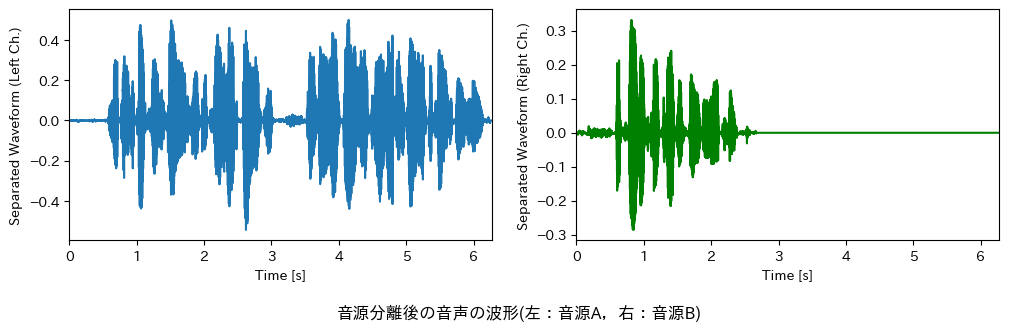

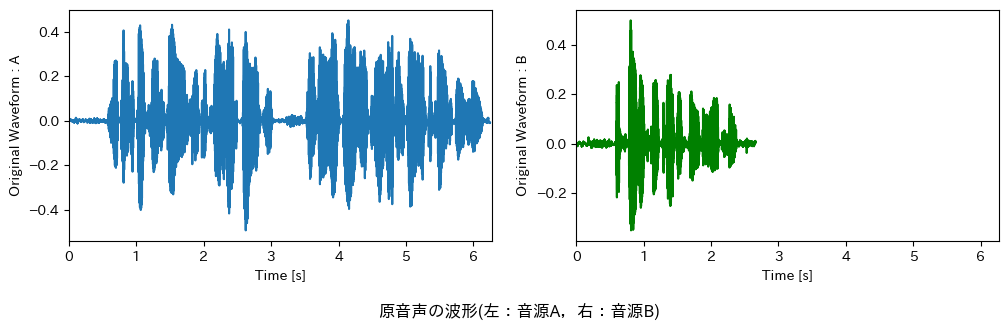

In [44]:
# 1 x 2 のグラフを２つ作成
fig4, ax4 = plt.subplots(1, 2, num=1, figsize=(12,3))
fig5, ax5 = plt.subplots(1, 2, num=2, figsize=(12,3))

# 各グラフをプロット
ax4[0].plot(t, y_a)                     # 原音声１
ax4[1].plot(t, y_b, color='g')      # 原音声２
ax5[0].plot(t1, originalA)           # 処理後の左チャンネル
ax5[1].plot(t2, originalB,color='g')# 処理後の左チャンネル

# x軸の範囲・ラベルの設定
for ax_ in np.r_[ax4,ax5]:
  ax_.set_xlim([t[0], t[-1]])
  ax_.set_xlabel("Time [s]")

# 軸のラベル・タイトルの設定
ax4[0].set_ylabel("Separated Waveform (Left Ch.)")
ax4[1].set_ylabel("Separated Waveform (Right Ch.)")
ax5[0].set_ylabel("Original Waveform : A")
ax5[1].set_ylabel("Original Waveform : B")
fig4.suptitle("音源分離後の音声の波形(左：音源A，右：音源B)", y=-0.1)
fig5.suptitle("原音声の波形(左：音源A，右：音源B)", y=-0.1)

処理音声を聞いて音源が分離できていることを確認します．

In [45]:
print('音源A')
display(Audio(originalA, rate = fs))
print('分離音源A')
display(Audio(y_a, rate = fs))

print('音源B')
display(Audio(originalB, rate = fs))
print('分離音源B')
display(Audio(y_b, rate = fs))

音源A


分離音源A


音源B


分離音源B


### 3. 音質評価

PESQによる音質評価を行います．

> PESQ :   
> ITUが標準化した音声品質評価指標 [[link](https://www.itu.int/rec/T-REC-P.862/en)]．評価音声に対する参照音声の類似度を，人間の聴覚特性を考慮して数値化したもの．
> PESQは -0.5～4.5の値をとり，評価音声と参照音声が一致するときに4.5の値となる．大きいほど参照音声に近いことを示す．


In [46]:
score_l = pesq(fs, originalA, y_a[:len(originalA)])
score_r = pesq(fs, originalB, y_b[:len(originalB)])
print("音源Aに対する分離音声のPESQ評価値 = {0:.2f} ({1:.1f}%)".format(score_l, 100*(score_l+0.5)/5))
print("音源Bに対する分離音声のPESQ評価値 = {0:.2f} ({1:.1f}%)".format(score_r, 100*(score_r+0.5)/5))

音源Aに対する分離音声のPESQ評価値 = 3.00 (69.9%)
音源Bに対する分離音声のPESQ評価値 = 1.61 (42.2%)


以下のコードで処理音声のwavファイルをダウンロードできます．
ダウンロードしたい場合にはコメントアウトを外してください．



In [ ]:
"""
sf.write('processed_sound2-3_l.wav', y_l, fs)
sf.write('processed_sound2-3_r.wav', y_r, fs)

from google.colab import files
files.download('processed_sound2-3_l.wav')
files.download('processed_sound2-3_r.wav')
"""

"\nsf.write('processed_sound2-3_l.wav', y_l, fs)\nsf.write('processed_sound2-3_r.wav', y_r, fs)\n\nfrom google.colab import files\nfiles.download('processed_sound2-3_l.wav')\nfiles.download('processed_sound2-3_r.wav')\n"